# Section 1

Analyses for Section 1 of the Manuscript.

In this notebook, we look whether complex models (transformers) can achieve a higher performance.

With SN10 we achieved 98% on vs Non-binder and 90% on vs Weak.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Skipping ONE_VS_ONE__1ADQ__3RAJ__0__0 because it does not exist.
Skipping ONE_VS_ONE__1ADQ__3VRL__0__0 because it does not exist.
Skipping ONE_VS_ONE__3RAJ__1ADQ__0__0 because it does not exist.
Skipping ONE_VS_ONE__3RAJ__3VRL__0__0 because it does not exist.
Skipping ONE_VS_ONE__3VRL__1ADQ__0__0 because it does not exist.
Skipping ONE_VS_ONE__3VRL__3RAJ__0__0 because it does not exist.
Skipping ONE_VS_ONE__1WEJ__1ADQ__0__0 because it does not exist.
Skipping ONE_VS_ONE__1WEJ__3RAJ__0__0 because it does not exist.
Skipping ONE_VS_ONE__1WEJ__3VRL__0__0 because it does not exist.
Skipping HIGH_VS_95LOW__1WEJ__auto__0__0 because it does not exist.
Skipping HIGH_VS_LOOSER__1WEJ__auto__0__0 because it does not exist.
Skipping ONE_VS_NINE__1WEJ__auto__0__0 because it does not exist.


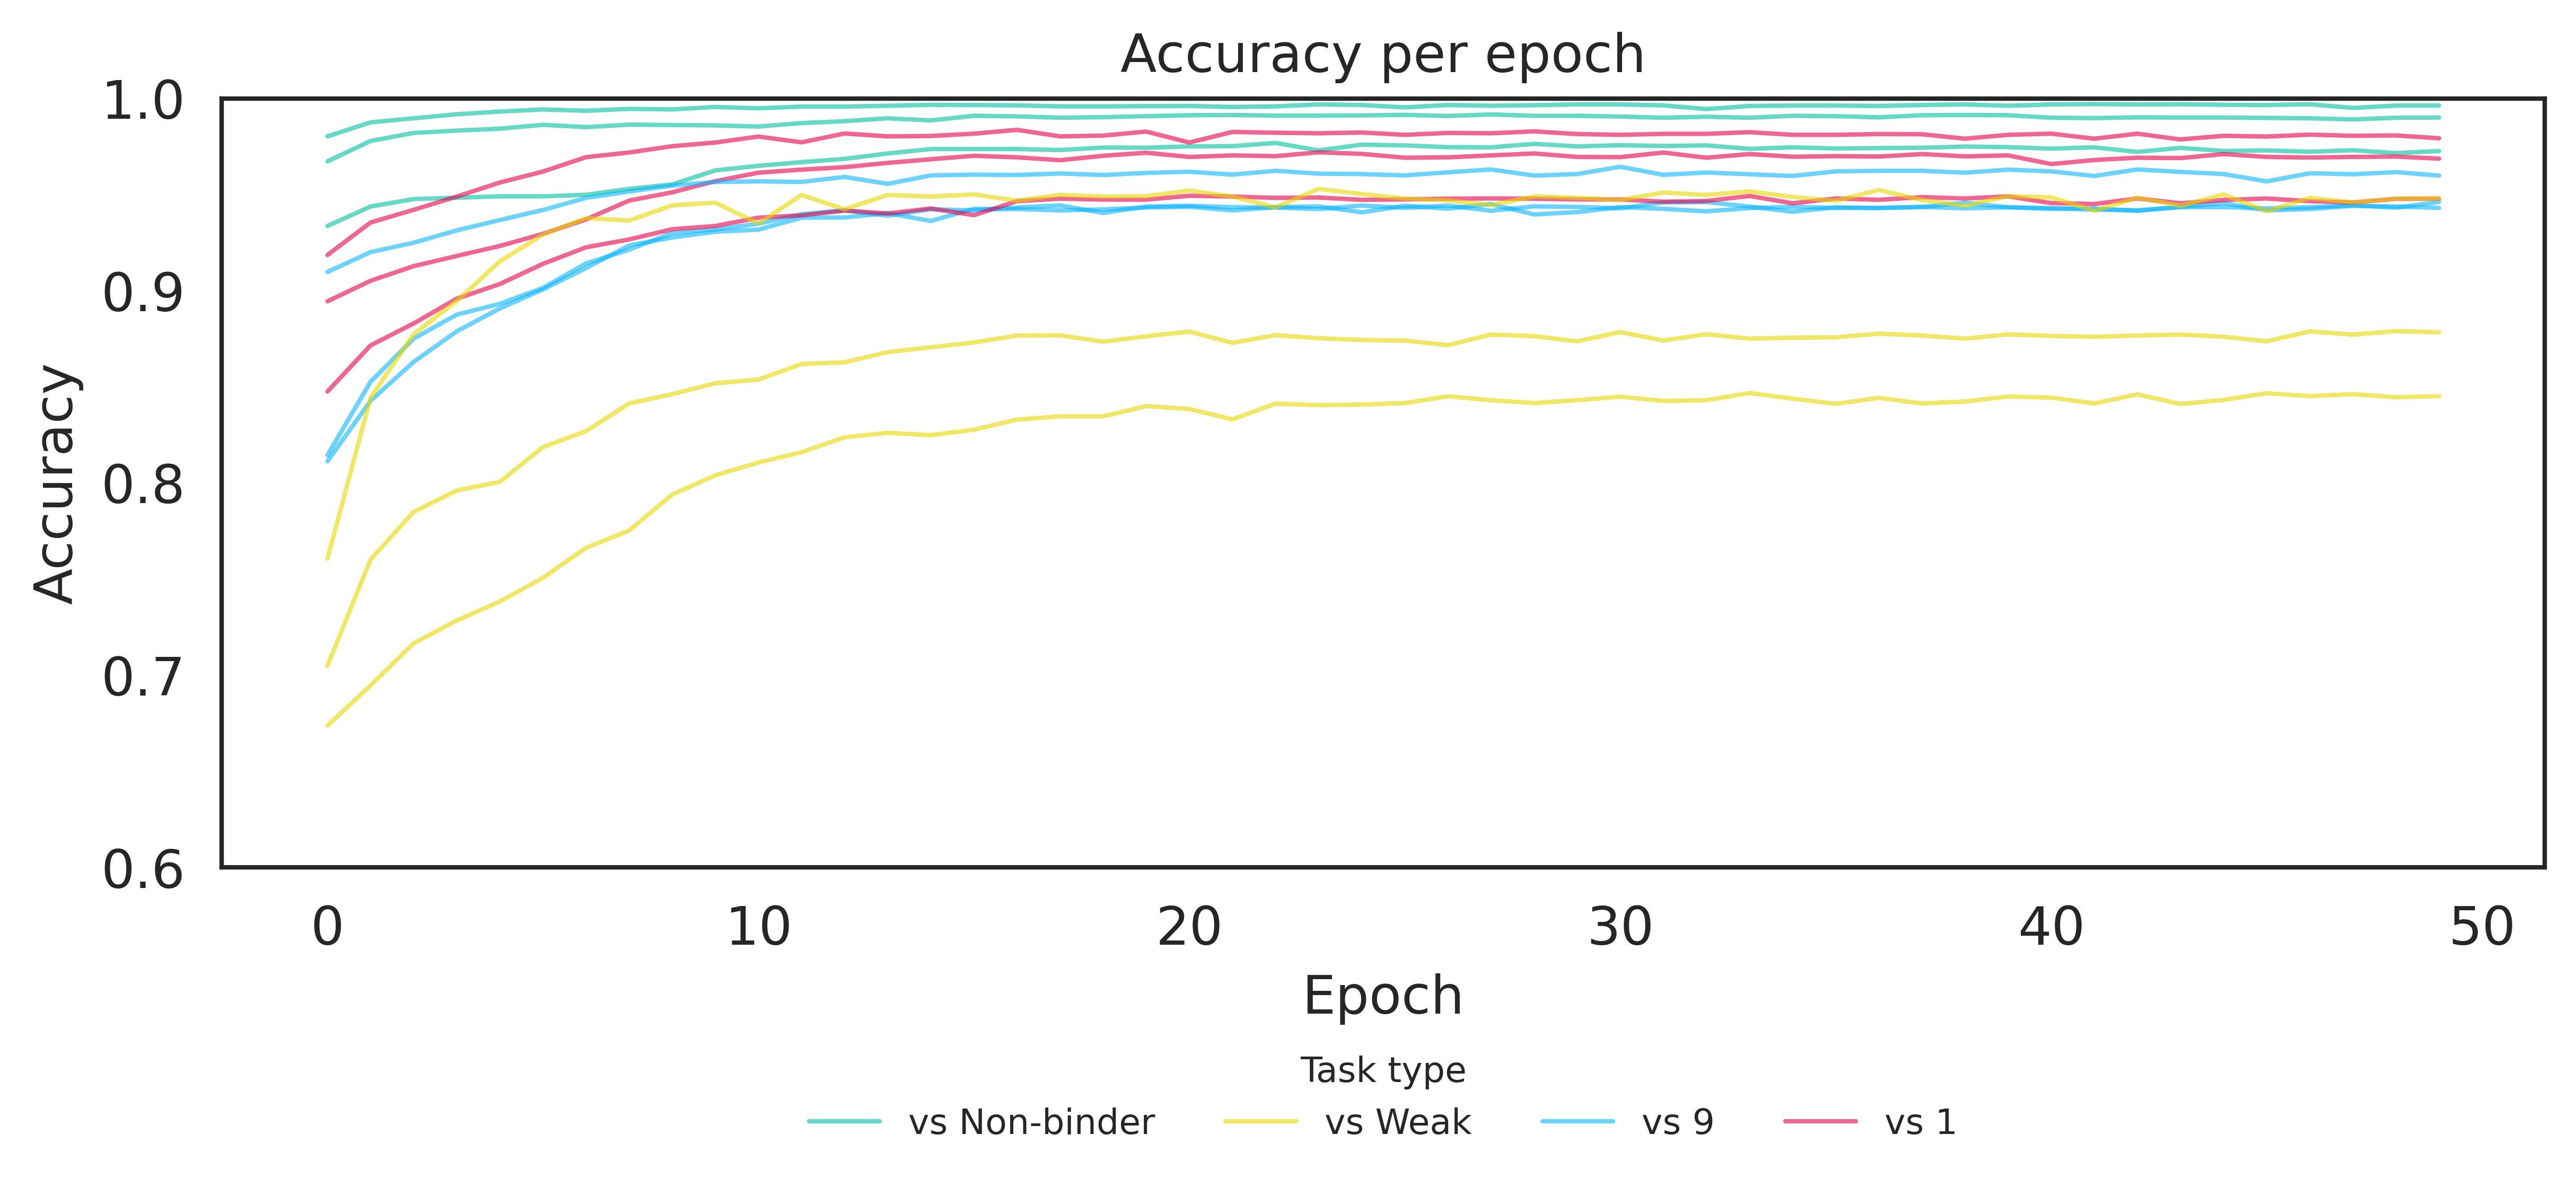

In [ ]:
base_pset_sel = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_Fitcheck"

seed_id = 0
split_ids = [0, 1, 2, 42]
task_types = [
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.ONE_VS_ONE,
]
antigens = ["1ADQ", "3RAJ", "3VRL", "1WEJ"]

# Figure prep
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)
# Set smaller size for the whole plot
# fig.set_size_inches(8, 4)
# fig.tight_layout()
cmap = visualisations.PlotParams.cmap_tasks
map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()

add_labels = True  # hack!
for ag1 in antigens[:]:
        for ag2 in antigens[:]:
            for seed_id, split_id in zip([seed_id], split_ids):
                for i, task_type in enumerate(task_types):
                    if (
                        task_type == datasets.ClassificationTaskType.ONE_VS_ONE
                        and ag1 == ag2
                    ):
                        continue
                    if (
                        task_type != datasets.ClassificationTaskType.ONE_VS_ONE
                        and ag1 != ag2
                    ):
                        continue

                    if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                        task = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag1,
                            ag_neg=ag2,
                            seed_id=seed_id,
                            split_id=split_id,
                        )
                    else:
                        task = datasets.ClassificationTask(
                            task_type=task_type,
                            ag_pos=ag1,
                            ag_neg="auto",
                            seed_id=seed_id,
                            split_id=split_id,
                        )

                    loader = datasets.FrozenMiniAbsolutMLLoader(
                        data_dir=base_pset_sel,
                    )
                    try:
                        task = loader.load(task, load_model=True)
                    except ValueError:
                        print(f"Skipping {task} because it does not exist.")
                        continue                                

                    online_metrics_json_fp = list((task.basepath / "epochs").glob("*"))[0]

                    # Open json
                    with open(online_metrics_json_fp, "r") as f:
                        online_metrics = json.load(f)

                    acc_per_epoch = []
                    for d in online_metrics:
                        acc_per_epoch.append(d["test_metrics"]["acc_closed"])

                    # Plot accuracy per epoch
                    # ax.plot(acc_per_epoch, color="blue", alpha=0.3)
                    
                    if add_labels:
                        sns.lineplot(
                            x=range(len(acc_per_epoch)),
                            y=acc_per_epoch,
                            ax=ax,
                            color=cmap[i],
                            label=map_task_type_to_clean[task_type.to_str()],
                            alpha=0.6,
                            linewidth=1,
                        )
                    else:
                        sns.lineplot(
                            x=range(len(acc_per_epoch)),
                            y=acc_per_epoch,
                            ax=ax,
                            color=cmap[i],
                            alpha=0.6,
                            linewidth=1,
                        )

                    # Hack to add labels just on 1 pass
                    if i == len(task_types) - 1 and add_labels:
                        add_labels = False
                        

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title(f"Accuracy per epoch", fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylim(0.6, 1)

# Legend: aggregate same labels
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=8,
    title="Task type",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

# ax.legend()
# Mark 2 horizontal lines corresponding to performance of SN10
# ax.axhline(0.98, color="blue", linestyle="--", linewidth=0.5)
# ax.axhline(0.90, color="orange", linestyle="--", linewidth=0.5)

# Show and save fig as svg
plt.show()
# fig.savefig("accuracy_per_epoch.svg", bbox_inches="tight")